In [19]:
import numpy as np
from torchvision.transforms import transforms
import librosa
import matplotlib.pyplot as plt
import torch
from PIL import Image
from scipy import signal

In [20]:
wav_path = r"E:\Datasets\IEMOCAP\raw_unzip\Session5\sentences\wav\Ses05F_script01_3\Ses05F_script01_3_F024.wav"

y,sr = librosa.load(wav_path,sr=None)
y_tensor = torch.as_tensor(y).unsqueeze(0)
y_tensor.shape

torch.Size([1, 39483])

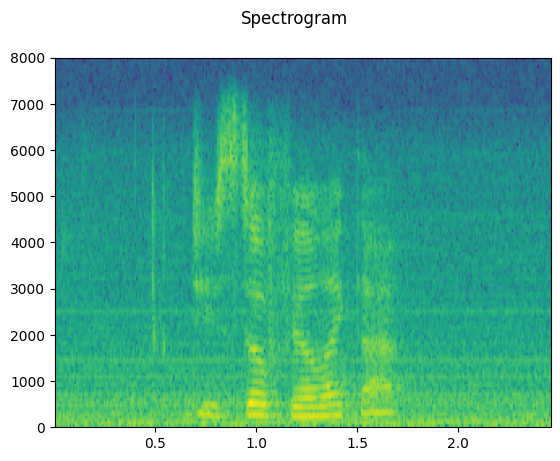

In [21]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    # require waveform [1,sample_points] and tensor
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c + 1}")
    figure.suptitle(title)
    plt.show(block=False)

plot_specgram(y_tensor,sr)

In [37]:
# style 1

def log_specgram(audio, sample_rate, window_size=40,
                 step_size=20, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    # print('noverlap',noverlap)
    # print('nperseg',nperseg)
    freqs, _, spec = signal.spectrogram(audio,
                                        fs=sample_rate,
                                        window='hann',
                                        nperseg=nperseg,
                                        noverlap=noverlap,
                                        detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

def get_3d_spec(Sxx_in, moments=None):
    if moments is not None:
        (base_mean, base_std, delta_mean, delta_std,
         delta2_mean, delta2_std) = moments
    else:
        base_mean, delta_mean, delta2_mean = (0, 0, 0)
        base_std, delta_std, delta2_std = (1, 1, 1)
    h, w = Sxx_in.shape
    # 将第1个时间步和所有的时间步水平concat 然后取最后一个时间步 作为right1 ？？？ [T,1]
    right1 = np.concatenate([Sxx_in[:, 0].reshape((h, -1)), Sxx_in], axis=1)[:, :-1]
    # delta 为原来的声谱图-去最后一个时间步，取第二个时间步之后的数据 [T,320]
    delta = (Sxx_in - right1)[:, 1:]
    # delta_pad 为上面的数据取第一个时间步 [T,1]
    delta_pad = delta[:, 0].reshape((h, -1))
    # 新的delta为delta重复一下第一个列数据
    delta = np.concatenate([delta_pad, delta], axis=1)
    # 得到第3个通道的方法 和 得到第2个通道的方法 一致
    right2 = np.concatenate([delta[:, 0].reshape((h, -1)), delta], axis=1)[:, :-1]
    delta2 = (delta - right2)[:, 1:]
    delta2_pad = delta2[:, 0].reshape((h, -1))
    delta2 = np.concatenate([delta2_pad, delta2], axis=1)
    # 每个通道进行归一化
    base = (Sxx_in - base_mean) / base_std
    delta = (delta - delta_mean) / delta_std
    delta2 = (delta2 - delta2_mean) / delta2_std
    # 三个通道concat 即可
    stacked = [arr.reshape((h, w, 1)) for arr in (base, delta, delta2)]
    return np.concatenate(stacked, axis=2)


# style 2


def _spec_to_rgb(data):
    """
    Convert normalized spectrogram to pseudo-RGB image based on pyplot color map
        and apply AlexNet image pre-processing

    Input: data
            - shape (N,C,H,W) = (num_spectrogram_segments, 1, Freq, Time)
            - data range [0.0, 1.0]
    """

    # AlexNet preprocessing
    alexnet_preprocess = transforms.Compose([
        # transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Get the color map to convert normalized spectrum to RGB
    cm = plt.get_cmap('jet')  # brg #gist_heat #brg #bwr

    # Flip the frequency axis to orientate image upward, remove Channel axis
    data = np.flip(data, axis=2)

    data = np.squeeze(data, axis=1)

    data_tensor = list()

    for i, seg in enumerate(data):
        seg = np.clip(seg, 0.0, 1.0)
        seg_rgb = (cm(seg)[:, :, :3] * 255.0).astype(np.uint8)

        img = Image.fromarray(seg_rgb, mode='RGB')

        data_tensor.append(alexnet_preprocess(img))

    return data_tensor[0]



(122, 321)


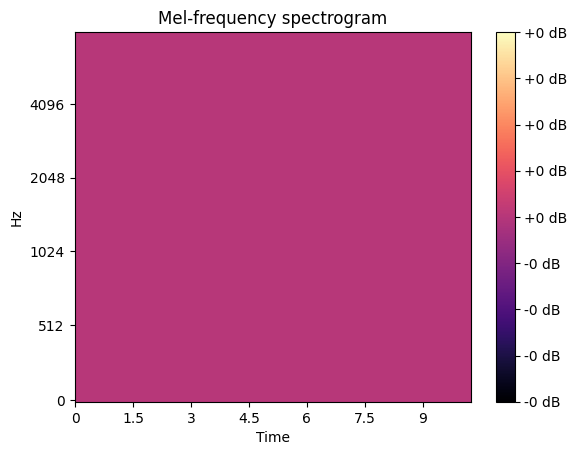

In [38]:
_,spec = log_specgram(y,sr)
print(spec.shape)
import librosa.display

def Visualize_the_Mel_Frequency_Spectrogram_series(S, sr):
    """
    Display of mel-frequency spectrogram coefficients, with custom
    arguments for mel filterbank construction (default is fmax=sr/2):
    :param S :  np.ndarray [shape=(..., n_mels, t)] Mel spectrogram
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr,ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')
    plt.show()

Visualize_the_Mel_Frequency_Spectrogram_series(S=spec,sr=sr)

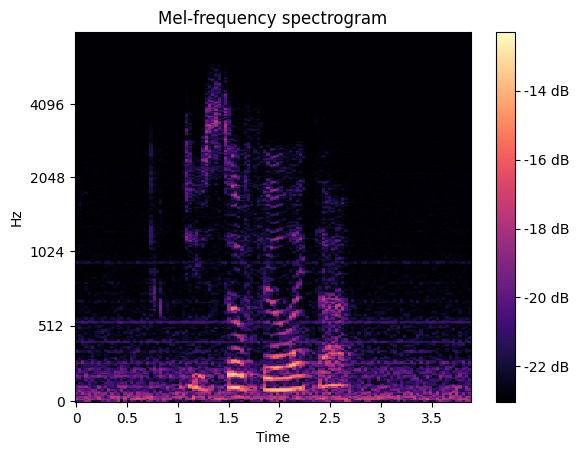

In [39]:
def Visualize_the_Mel_Frequency_Spectrogram(Spec, sr):
    """
    Display of mel-frequency spectrogram coefficients, with custom
    arguments for mel filterbank construction (default is fmax=sr/2):
    :param S :  np.ndarray [shape=(..., n_mels, t)] Mel spectrogram
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    img = librosa.display.specshow(Spec, x_axis='time', y_axis='mel', sr=sr,ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')
    plt.show()

Visualize_the_Mel_Frequency_Spectrogram(Spec=spec.T,sr=sr)

In [41]:
style1_3d = get_3d_spec(spec)

style2_3d = _spec_to_rgb(torch.as_tensor(spec.T).unsqueeze(0).unsqueeze(0).numpy())

style1_3d = torch.as_tensor(style1_3d).permute([2,0,1])
style2_3d = torch.as_tensor(style2_3d).permute([0,2,1])

style1_3d.shape,style2_3d.shape


(torch.Size([3, 122, 321]), torch.Size([3, 122, 321]))

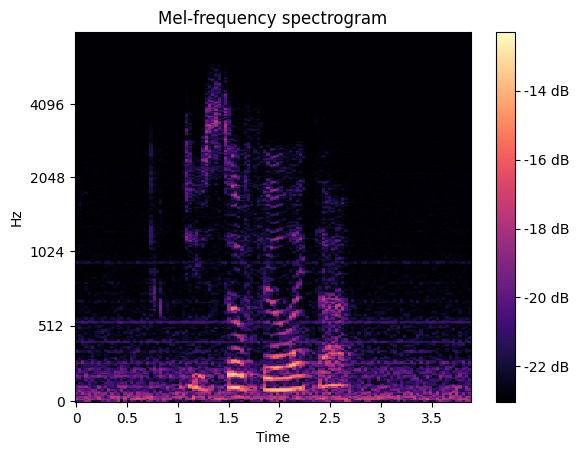

In [49]:
Visualize_the_Mel_Frequency_Spectrogram(style1_3d[0,:,:].T.numpy(),sr=sr)

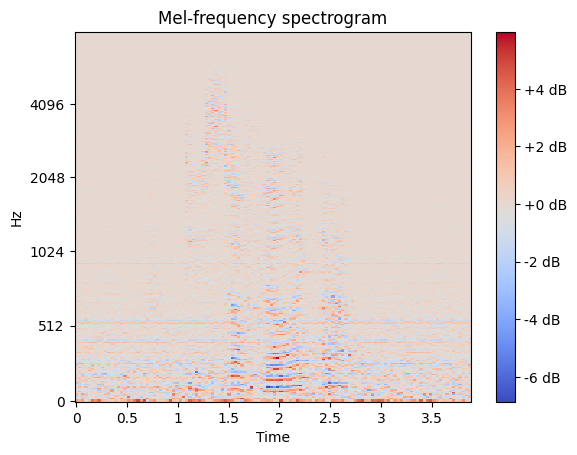

In [50]:
Visualize_the_Mel_Frequency_Spectrogram(style1_3d[1,:,:].T.numpy(),sr=sr)

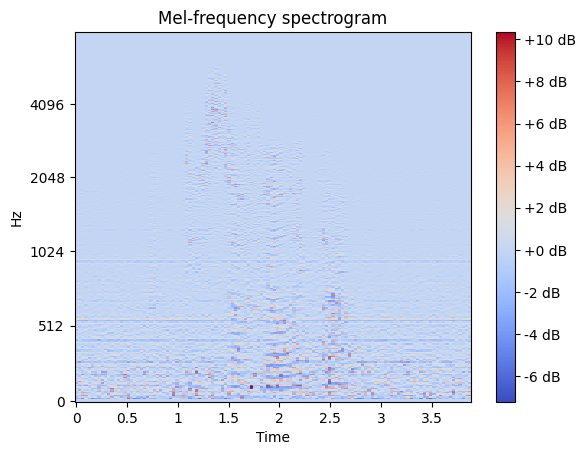

In [51]:
Visualize_the_Mel_Frequency_Spectrogram(style1_3d[2,:,:].T.numpy(),sr=sr)

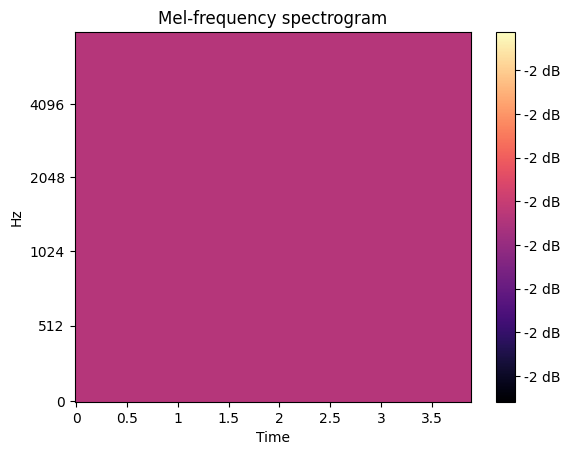

In [55]:
Visualize_the_Mel_Frequency_Spectrogram(style2_3d[0,:,:].T.numpy(),sr=sr)

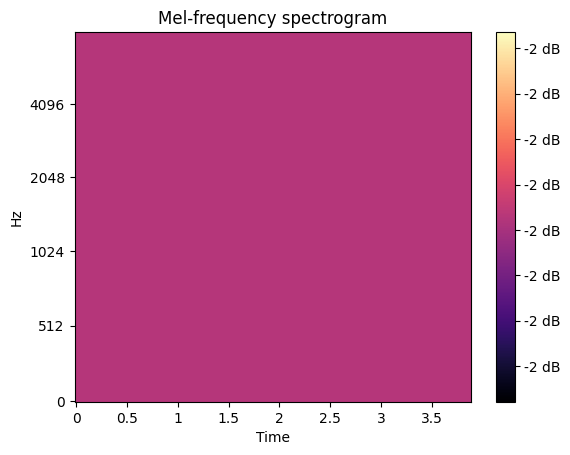

In [56]:
Visualize_the_Mel_Frequency_Spectrogram(style2_3d[1,:,:].T.numpy(),sr=sr)

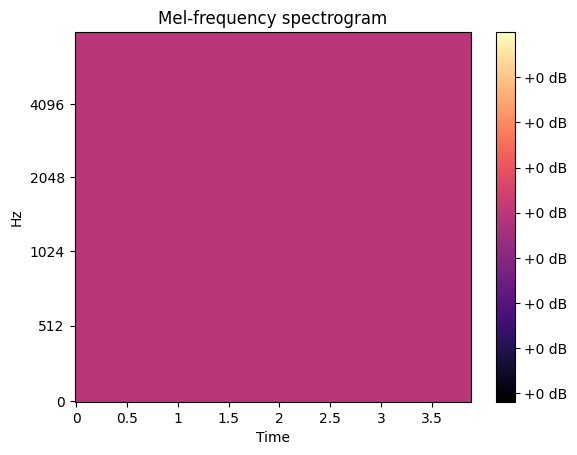

In [57]:
Visualize_the_Mel_Frequency_Spectrogram(style2_3d[2,:,:].T.numpy(),sr=sr)